In [1]:
import time
import numpy as np
import pandas as pd
from scipy.special import softmax
import matplotlib.pyplot as plt
from scipy.special import logsumexp
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import OneHotEncoder

EARLY_STOP_ACC_TOL = 0.01

# Synthetic Dataset Construction

In [3]:
## Initialize random data (A matrix)
m = 1000 # number of examples
d = 1000 # dim of example
k = 50 # number of output classes
# Data init
A = np.random.normal(0,1,size=(m,d)) # (# examples, dim examples)
# Param init
X = np.random.normal(0,1,size=(d,k)) # (dim examples, # classes)
E = np.random.normal(0,1,size=(m,k)) 
# Generate target classes
#b_i = np.random.randint(1, k+1, size=(m,1))
#b_i_zeroidx = b_i - 1
I_k = np.eye(k)

# This is a kinda strange way of generating data
b = np.dot(A,X) + E # (m,k)
b_i = b.argmax(axis=1) # zero indexed!
b_onehot = I_k[b_i]

# Each model will use the same initial parameters, but different than the ones used to generate the toy data.
X0 = np.random.normal(0,1,size=(d,k))
#X0 = np.zeros_like(X)

In [4]:
# for sanity
num_examples = m
example_dim = d
num_classes = k


# Full Gradient Descent

In [5]:
def grad(A, Y, X):
    Z = - A @ X
    probs = softmax(Z, axis=1)
    m = A.shape[0]
    grad_X = 1/m * (A.T @ (Y - probs))
    return grad_X

def loss(A, Y, X, Z = None):
    Z = - A @ X if Z is None else Z # avoids recalculating
    num_samples = A.shape[0]
    loss = 1/num_samples * (np.trace(A @ X @ Y.T) + np.sum(np.log(np.sum(np.exp(Z), axis=1))))
    return loss

def fast_loss(A, Y, X, Z=None):
    if Z is None:
        Z = -A @ X  # Compute Z only if not provided
    num_samples = A.shape[0]

    # Efficient computation of the trace term
    AX = A @ X
    trace_term = np.sum(AX * Y)

    # Efficient and stable log-sum-exp computation
    log_sum_exp = logsumexp(Z, axis=1)

    # Final computation of the loss
    loss = 1 / num_samples * (trace_term + np.sum(log_sum_exp))
    return loss

def accuracy(X, Z = None):
    Z = - A @ X if Z is None else Z # avoids recalculating
    predictions = softmax(Z)
    predicted_labels = np.argmax(predictions, axis=1)
    actual_labels = b_i #np.argmax(b_onehot, axis=1)
    accuracy = np.mean(predicted_labels == actual_labels)
    return accuracy

def gd(A, b_onehot, max_iter=1000, step_size=0.1):
    X_cur = np.copy(X0)
    start_time_p = time.process_time()
    start_time_w = time.time()
    hist = []
    for i in range(max_iter):
        g = grad(A, b_onehot, X_cur)
        X_cur -= step_size * g
        Z = - A @ X_cur
        # Note that calculating metrics takes CPU time
        # When compairng histories, should calculate roughly the same maetics 
        hist_row = {
            'iter': i,
            'loss': loss(A, b_onehot, X_cur ,Z),
            'accuracy': accuracy(X_cur, Z),
            'grad_mag': np.linalg.norm(g, 2),
            'cpu_time': time.process_time() - start_time_p, # parallization will make this longer than exec time!
            'wall_time': time.time() - start_time_w
            }
        hist.append(hist_row)
        if 1 -  hist_row['accuracy'] < EARLY_STOP_ACC_TOL:
            break

    hist_df = pd.DataFrame(hist)
    return hist_df

In [6]:
def F_norm(A):
    return np.dot(A.T, A)

def lipschitz_approx(A):
    H = F_norm(A)
    eigenvalues = np.linalg.eigvalsh(H)
    return np.max(np.abs(eigenvalues))

# Example usage
L = lipschitz_approx(A)
print("Approximated Lipschitz constant:", L)

Approximated Lipschitz constant: 4002.132321515932


In [6]:
1/L

0.0002526851399283752

In [7]:
hist_gd_df = gd(A,b_onehot, step_size=3.3)
hist_gd_df

,iter,loss,accuracy,grad_mag,cpu_time,wall_time
0,0,62.134410,0.042,0.278159,0.000000,0.017705
1,1,55.918616,0.054,0.271599,0.031250,0.036746
2,2,50.121621,0.070,0.258579,0.125000,0.050291
3,3,44.731996,0.101,0.246898,0.265625,0.064648
4,4,39.771390,0.128,0.236133,0.375000,0.078220
5,5,35.195248,0.164,0.227876,0.468750,0.094765
6,6,30.968937,0.197,0.223229,0.593750,0.107926
7,7,27.051587,0.234,0.218441,0.671875,0.121635
8,8,23.486866,0.297,0.211880,0.750000,0.134138
9,9,20.294629,0.348,0.203784,0.828125,0.146260


# BCGD

In [7]:
L = 0.01
alpha = 1/L

In [8]:
# TODO: implement a faster version that calculates just the ith component
def gs_coord_select(X):
    """"
    Step 4 in the BCGD with GS rule.
    Picks block with maximial gradient
    we select a COORDINATE meaning we get the col of the gradient with biggest magnitude
    Using the full gradeint is more expensive that calculating just a component.
    But is needed here since we need to choose the block of max change
    """
    g = grad(A, b_onehot, X)
    i_k = np.argmax(np.linalg.norm(g, 2, axis = 0)) # select the coord (col)
    g_ik = g[:,i_k].reshape((example_dim,1))
    return g_ik, i_k

def coord_step(X0, i_k, g_ik, alpha=alpha):
    step = - alpha * g_ik
    #X_out = X0
    X0[:,i_k] += step.flatten()
    return {'step_size':alpha}#X_out

def gs_coord_select_T(X):
    """"
    Step 4 in the BCGD with GS rule.
    Picks block with maximial gradient
    we select a COORDINATE meaning we get the col of the gradient with biggest magnitude
    Using the full gradeint is more expensive that calculating just a component.
    But is needed here since we need to choose the block of max change
    """
    g = grad(A, b_onehot, X)
    i_k = np.argmax(np.linalg.norm(g, 2, axis = 1)) # select the coord (row)
    
    g_ik = g[i_k,:].reshape((num_classes,1))
    return g_ik, i_k

def coord_step_T(X0, i_k, g_ik, alpha=alpha):
    step = - alpha * g_ik
    X_out = X0
    X_out[i_k,:] += step.flatten()
    return X_out


# TODO: check optimality condition for early stopping.
def BCGD(coord_select, coord_step=coord_step, max_iter = 100, return_hist = True, step_size = alpha):
    # X_DEBUG = None
    X_cur = np.copy(X0)
    hist = []
    start_time_p = time.process_time()
    start_time_w = time.time()
    for iter in range(max_iter):
        hist_iter = {'iter': iter}
        g_ik, i_k = coord_select(X_cur)
        #X_cur = coord_step(X_cur, i_k, g_ik)
        step_stats = coord_step(X_cur, i_k, g_ik, alpha=step_size)
        # if iter == 5:
        #     X_DEBUG = np.copy(X_cur)
        #     print('whoo')
        if return_hist:
            Z = - A @ X_cur
            hist_iter = {
                'iter': iter,
                'loss': loss(A, b_onehot, X_cur, Z),
                'accuracy': accuracy(X_cur, Z),
                'i_k': i_k,
                'L2_g_ik': np.linalg.norm(g_ik,2),
                'cpu_time': time.process_time() - start_time_p, # parallization will make this longer than exec time!
                'wall_time': time.time() - start_time_w
                }
            hist_iter.update(step_stats)
            hist.append(hist_iter)
            # early stopping
            if 1 - hist_iter['accuracy'] < 0.01:
                break
    if return_hist:
        return pd.DataFrame(hist)#, X_DEBUG
    else:
        return
    
def grad_block(A, Y, X, i_k):
    # used for BCGD with random rule because you dont need full gradient
    Z = -A @ X
    probs = softmax(Z, axis=1)
    m = A.shape[0]
    # Compute only the i_k-th column of the gradient
    grad_X_ik = 1/m * A.T @ (Y[:, i_k] - probs[:, i_k])
    return grad_X_ik

def rand_coord_select(X):
    # TODO: CALCULATING THE FULL GRAD HERE IS NOT NECESSARY
    # [IMPORTANT] it will run faster if this is optimized.
    i_k = np.random.randint(num_classes) # select the coord (col)
    #g = grad(A, b_onehot, X)
    #g_ik = g[:,i_k].reshape((example_dim,1))
    g_ik = grad_block(A, b_onehot, X, i_k)
    return g_ik, i_k

In [10]:
hist_BCGD_GS_df = BCGD(gs_coord_select, max_iter=200, step_size=50)
hist_BCGD_GS_df

,iter,loss,accuracy,i_k,L2_g_ik,cpu_time,wall_time,step_size
0,0,67.199096,0.038,46,0.250272,0.000000,0.012375,50
1,1,65.304260,0.052,19,0.245423,0.078125,0.023369,50
2,2,63.792610,0.059,12,0.243482,0.140625,0.039217,50
3,3,62.279321,0.066,36,0.237905,0.250000,0.053201,50
4,4,60.790237,0.076,25,0.235414,0.343750,0.066434,50
...,...,...,...,...,...,...,...,...
115,115,0.129793,0.985,28,0.041734,9.796875,1.411981,50
116,116,0.117814,0.987,26,0.039904,9.859375,1.425413,50
117,117,0.107711,0.989,43,0.039769,9.953125,1.438101,50
118,118,0.101686,0.990,30,0.039574,10.109375,1.447012,50


In [11]:
g_ik, i_k = gs_coord_select(X0)
X_cur = np.copy(X0)
step_size = 0.5
ls_hist = []
for i in range(400):
        step = - g_ik
        last_i = i
        X_cur[:,i_k] += step_size * step.flatten()
        l = loss(A,b_onehot, X_cur)#
        ls_hist.append({'step':0,'loss':l,'step_size':step_size*i})
ls_hist = pd.DataFrame(ls_hist)
ls_hist

,step,loss,step_size
0,0,68.812257,0.0
1,0,68.781434,0.5
2,0,68.751046,1.0
3,0,68.721177,1.5
4,0,68.691900,2.0
...,...,...,...
395,0,67.629128,197.5
396,0,67.639406,198.0
397,0,67.649748,198.5
398,0,67.660154,199.0


Text(0.5, 1.0, 'Loss vs stepsize over Block Line Search')

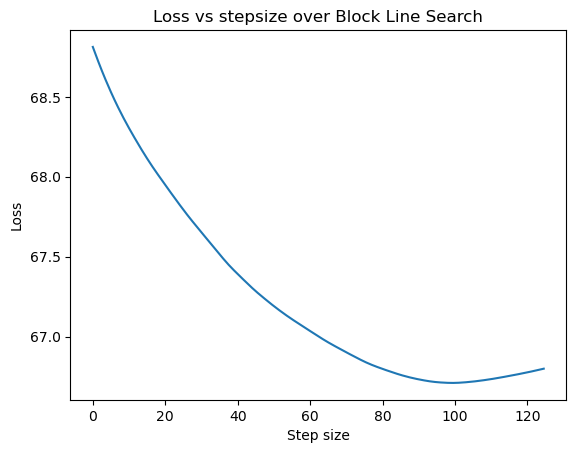

In [12]:
# plot for writeup
plt.plot(ls_hist['step_size'][:250], ls_hist['loss'][:250])
plt.xlabel('Step size')
plt.ylabel('Loss')
plt.title('Loss vs stepsize over Block Line Search')

In [13]:
def coord_step_linesearch(X_cur, i_k, g_ik, alpha:float):
    #hist_ls = []
    prev_loss = 1e10
    last_i = 0
    for i in range(100):
        step = - g_ik
        last_i = i
        X_cur[:,i_k] += alpha * step.flatten()
        l = fast_loss(A,b_onehot, X_cur)#
        # hist_ls.append({
        #     'iter': i,
        #     'loss': l
        # })
        if l > prev_loss:
            # by convexity, if the loss increases along our line search, stop searching.
            X_cur[:,i_k] -= alpha * step.flatten() # this is wastful: undoing work, but probably better than maintining the last X in memory
            break
        prev_loss = l
# ls_df = pd.DataFrame(hist_ls)
# ls_df
    return {'step_size': alpha * last_i, 'ls_steps':last_i}

In [14]:
hist_BCGD_GS_ls_df = BCGD(gs_coord_select, coord_step=coord_step_linesearch, max_iter=100, step_size=5)
hist_BCGD_GS_ls_df

,iter,loss,accuracy,i_k,L2_g_ik,cpu_time,wall_time,step_size,ls_steps
0,0,66.709798,0.050,46,0.250272,0.546875,0.162950,100,20
1,1,64.565962,0.079,19,0.243949,1.062500,0.278342,80,16
2,2,62.652097,0.097,12,0.238231,2.015625,0.407634,100,20
3,3,60.794104,0.118,25,0.235785,2.875000,0.519421,90,18
4,4,58.891677,0.135,36,0.240139,3.796875,0.635550,90,18
...,...,...,...,...,...,...,...,...,...
74,74,0.188341,0.985,15,0.048087,51.093750,7.500150,30,6
75,75,0.173053,0.986,31,0.047291,51.578125,7.566478,45,9
76,76,0.157372,0.988,19,0.046177,52.015625,7.643011,50,10
77,77,0.146570,0.989,44,0.043207,52.921875,7.782332,105,21


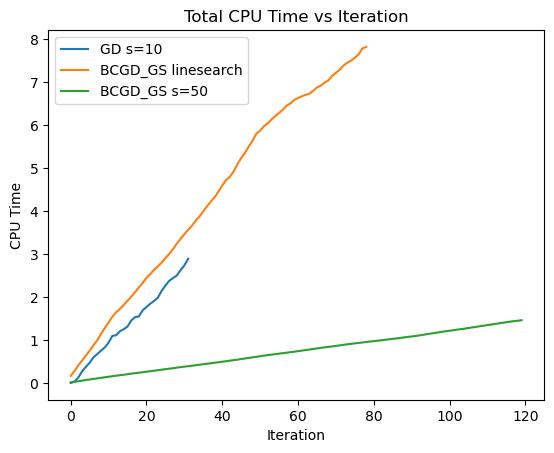

In [15]:
plt.plot(hist_gd_df['iter'], hist_gd_df['cpu_time'], label='GD s=10')
plt.plot(hist_BCGD_GS_ls_df['iter'],hist_BCGD_GS_ls_df['wall_time'], label='BCGD_GS linesearch')
plt.plot(hist_BCGD_GS_df['iter'],hist_BCGD_GS_df['wall_time'], label='BCGD_GS s=50')
plt.title('Total CPU Time vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('CPU Time')
plt.legend()

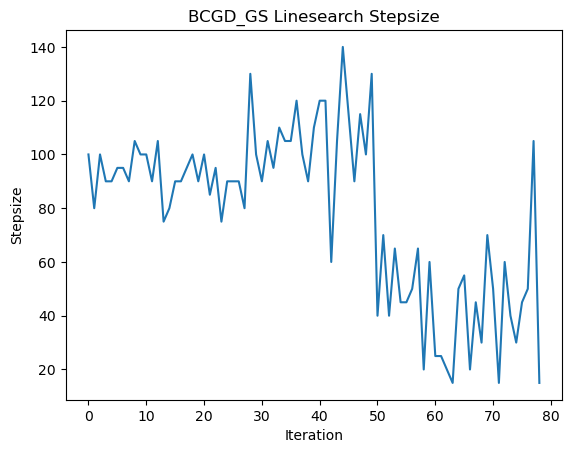

In [16]:
plt.plot(hist_BCGD_GS_ls_df['iter'], hist_BCGD_GS_ls_df['step_size'])
plt.xlabel('Iteration')
plt.ylabel('Stepsize')
plt.title('BCGD_GS Linesearch Stepsize')
plt.show()

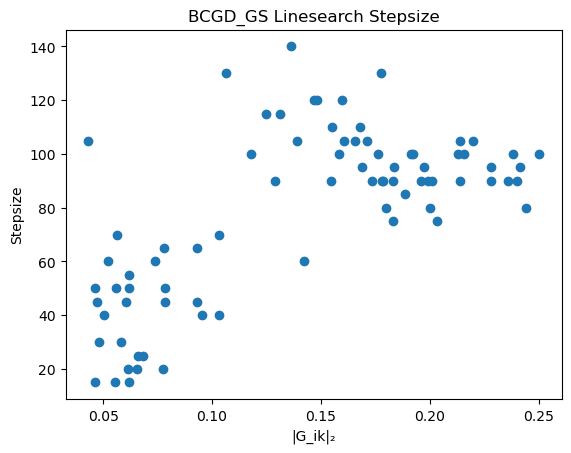

In [17]:
plt.scatter(hist_BCGD_GS_ls_df['L2_g_ik'], hist_BCGD_GS_ls_df['step_size'])
plt.xlabel('|G_ik|₂')
plt.ylabel('Stepsize')
plt.title('BCGD_GS Linesearch Stepsize')
plt.show()

# CORE BCGD METHODS

In [18]:
hist_BCGD_rand_df = BCGD(rand_coord_select, max_iter=500, step_size=50)
hist_BCGD_rand_df

,iter,loss,accuracy,i_k,L2_g_ik,cpu_time,wall_time,step_size
0,0,66.943808,0.047,19,0.248787,0.000000,0.014272,50
1,1,66.238934,0.054,7,0.152067,0.140625,0.026792,50
2,2,64.966574,0.063,4,0.198870,0.328125,0.050089,50
3,3,63.888892,0.069,5,0.199878,0.328125,0.065400,50
4,4,62.586356,0.075,20,0.208292,0.421875,0.080111,50
...,...,...,...,...,...,...,...,...
290,290,0.584458,0.985,25,0.033784,28.203125,3.996643,50
291,291,0.584237,0.985,33,0.004943,28.265625,4.011744,50
292,292,0.584235,0.985,28,0.000206,28.359375,4.027869,50
293,293,0.584227,0.985,16,0.000434,28.453125,4.041968,50


In [19]:
def plot_hist(X_val, Y_val, dfs, legend_lables, title = None):
    # Checking optimality conditions
    # want to plot only the histories before cond. met.

    fig = plt.figure()
    for i, hist_df in enumerate(dfs):
        plt.plot(hist_df[X_val], hist_df[Y_val], label=legend_lables[i])
    # plt.plot(hist_gd_df[gd_sele][X_val], hist_gd_df[gd_sele][Y_val], label='GD')
    # plt.plot(hist_BCGD_GS_df[gs_sele][X_val], hist_BCGD_GS_df[gs_sele][Y_val], label='GS')
    # plt.plot(hist_BCGD_rand_df[rand_sele][X_val], hist_BCGD_rand_df[rand_sele][Y_val], label = 'Random')
    plt.legend()
    plt.xlabel(X_val)
    plt.ylabel(Y_val)
    if title is not None:
        plt.title(title)
    plt.show()

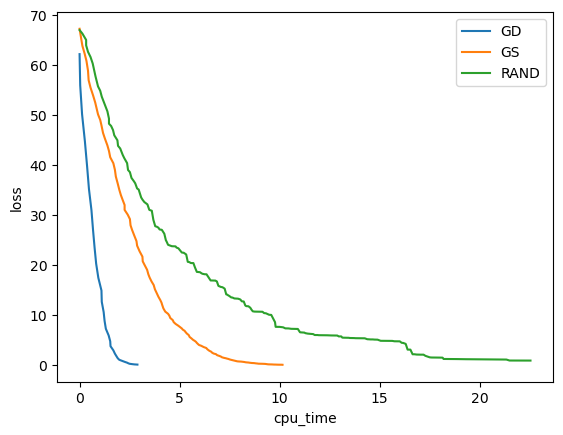

In [20]:
gd_sele = (hist_gd_df['grad_mag'] < 0.01).cumsum() == 0
gs_sele = (hist_BCGD_GS_df['L2_g_ik'] < 0.01).cumsum() == 0
rand_sele = (hist_BCGD_rand_df['L2_g_ik'] < 0.01).cumsum() < 30 # patience for random because prev. selected coords have low grad and can stop prematurely.
plot_hist('cpu_time', 'loss', [hist_gd_df[gd_sele], hist_BCGD_GS_df[gs_sele], hist_BCGD_rand_df[rand_sele]], ['GD', 'GS', 'RAND'])

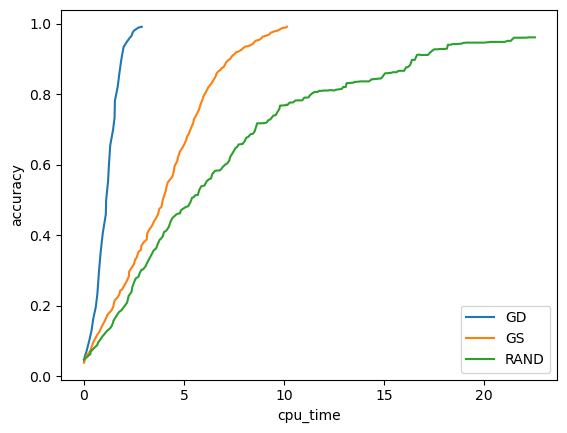

In [21]:
plot_hist('cpu_time', 'accuracy', [hist_gd_df[gd_sele], hist_BCGD_GS_df[gs_sele], hist_BCGD_rand_df[rand_sele]], ['GD', 'GS', 'RAND'])

# MNIST DATASET

In [9]:
optical_recognition_of_handwritten_digits = fetch_ucirepo(id=80) 
  
# data (as pandas dataframes) 
digits_feats_df = optical_recognition_of_handwritten_digits.data.features / 16
digits_target_df = optical_recognition_of_handwritten_digits.data.targets 
 
digits_mask = digits_target_df['class'].isin([0,1,2,3,4])
digits_feats_df = digits_feats_df[digits_mask]
digits_target_df = digits_target_df[digits_mask]

ConnectionError: Error connecting to server

In [45]:
b_names = digits_target_df['class'].to_numpy().reshape(-1,1) # rows are examples
b_cat_names = digits_target_df['class'].unique()
b_cat_names

OH_encoder = OneHotEncoder(sparse=False)
b_onehot = OH_encoder.fit_transform(b_names)
b_i = np.argmax(b_onehot, axis=1) # number corresponding to the class
A = digits_feats_df.to_numpy(dtype=float)
num_examples, example_dim = A.shape
num_classes = len(b_cat_names)
X0 = np.random.normal(0,1,size=(example_dim,num_classes))

c:\Source\Anaconda\envs\Frank\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [46]:
lipschitz_approx(A)

29952.626530946007

In [67]:
step_size_digits = 1.5

In [68]:
digits_gd_df = gd(A,b_onehot, max_iter=1000, step_size=step_size_digits)

In [69]:
digits_bcgd_gs_df = BCGD(gs_coord_select, step_size=step_size_digits, max_iter=1000)

In [73]:
digits_bcgd_rand_df = BCGD(rand_coord_select, step_size=step_size_digits, max_iter=1000)

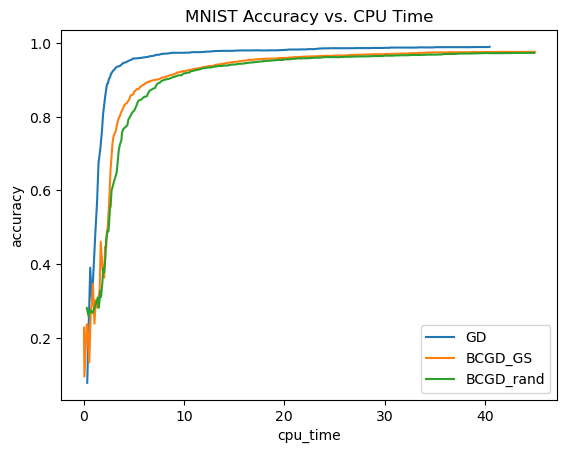

In [81]:
plot_hist('cpu_time', 'accuracy', [digits_gd_df, digits_bcgd_gs_df[digits_bcgd_gs_df['cpu_time'] < 45], digits_bcgd_rand_df[digits_bcgd_rand_df['cpu_time'] < 45]], ['GD', 'BCGD_GS', 'BCGD_rand'], title = "MNIST Accuracy vs. CPU Time")


# Emperical estimation of Lipschitz Constant

In [54]:
#grad(A, b_onehot, np.random.randn(0,1))
#L = []
#L_block = []
#L_block_norm = []
vars = [1]#, 0.5, 0.25, 0.1]
L_hist = []
for cur_var in vars:
    for i in range(100):
        X_rand = np.random.normal(0,0.5,size=(example_dim,num_classes))
        Y_rand = np.random.normal(0,0.5,size=(example_dim,num_classes))
        X_grad = grad(A, b_onehot, X_rand)
        Y_grad = grad(A, b_onehot, Y_rand)
        L_full = np.linalg.norm(X_grad - Y_grad,2)/np.linalg.norm(X_rand - Y_rand,2)
        #L.append(L_full)
        block_idx = np.random.randint(num_classes)
        X_grad_rand = grad_block(A, b_onehot, X_rand, block_idx)
        Y_grad_rand = grad_block(A, b_onehot, Y_rand, block_idx)
        X_grad_rand = grad_block(A, b_onehot, X_rand, block_idx)
        Y_grad_rand = grad_block(A, b_onehot, Y_rand, block_idx)
        L_block = np.linalg.norm(X_grad_rand - Y_grad_rand,2)/np.linalg.norm(X_rand - Y_rand,2)
        L_hist.append({'i':i, 'var':cur_var, 'L_full':L_full, 'block_idx':block_idx, 'L_block':L_block})
L_hist = pd.DataFrame(L_hist)

In [60]:
1 / L_hist['L_block'].mean()

144.16042123643118